In [2]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

## Importing Sample Data to test signals on

In [206]:
stock = yf.Ticker("MSFT").history(period="30y")

# Signals

This Notebook will contain the generation of various technical, and technological signals. 

## Structure

- Each signal will be calculated via a function 
- Each function will take in a time series as a pandas dataframe and any other relevant hyperparameters e.g. #days for a moving average

### Moving Average and Moving Average Crossover functions

In [281]:
def moving_average(series, lookback):
    """
    Takes in a pandas dataframe time series and a number of days hyperparameter. 
    Outputs the moving average of the time series as a pandas dataframe. 
    """
    ma = series.rolling(lookback).mean()
    return ma

def ma_crossover(ma1, ma2, strat="mom"):
    """
    This function calculates the moving average crossover signal. It automatically assumes the signal is based off of a 
    momentum strategy. 
    Inputs:
    - ma1: the long term moving average
    - ma2: the short term moving average 
    - strat: a string defining whether the strategy is momentum-"mom" or mean reversion-"mv"
    """
    
    # treating the data by ensuring: 1) no nans; 2) long term MA same length as short term MA
    ma1 = ma1.dropna()
    ma2 = ma2.dropna()
    ma2 = ma2[ma1.index]
    
    # if momentum strategy
    if strat=="mom":
        
        # locations where ma2 (short term MA) >= ma1 (long term MA): returns booleans
        smax = ma2.ge(ma1)
        
        # converts booleans to integers
        smax = smax.astype(int)
        
        return smax
    
    elif strat=="mv":
        
        # locations where ma1 (long term MA) >= ma2 (long term MA): returns booleans
        smax = ma1.ge(ma2)
        
        # converts booleans to integers
        smax = smax.astype(int)
        
        return smax
        
    else: 
        print("'strat' string is invalid. Please define whether the signal should be based off of a momentum 'mom' or mean reverting strategy.")
        
# validating the functions - working        
stock["200ma"] = moving_average(stock["Close"], 200)
stock["50ma"] = moving_average(stock["Close"], 50)
stock["Crossover_Signal"] = ma_crossover(stock["200ma"], stock["50ma"])

### Exponential Moving Average

In [283]:
def exponential_ma(series, lookback):
    """
    Takes in a pandas dataframe time series and a number of days hyperparameter. 
    Outputs the exponential moving average of the time series as a pandas dataframe. 
    """
    
    exp_ma = series.ewm(span=lookback, min_periods=lookback).mean().dropna()
    
    return exp_ma

### Relative Strength Index (RSI)

In [346]:
def rsi(series, lookback):
    """
    This function returns the RSI of an input pandas series.
    The inputs are:
    - series: the input pandas series to calculate the RSI on
    - lookback: the number of days to look back over to calculate the RSI; usually lookback=14
    """
    
    # difference the data and calculate the returns
    delta = series.diff().dropna()

    # obtain the positive and negative returns while clipping out of range values at 0
    up, down = abs(delta.clip(lower=0).rename("Up")), abs(delta.clip(upper=0).rename("Down"))

    # calculate the rolling average gains and losses excluding the 0 values
    avg_gain = up.rolling(lookback).apply(lambda x: x[x!= 0].mean()).dropna().rename("Avg Gain")
    avg_loss = down.rolling(lookback).apply(lambda x: x[x!= 0].mean()).dropna().rename("Avg Loss")

    # calculating the denominator of the RSI
    RSI_step = 1 + ((avg_gain.shift(1)*(lookback-1)) + up)/((avg_loss.shift(1)*(lookback-1)) + down)

    # obtain the RSI
    RSI = 100 - 100/RSI_step
    
    return RSI 

RSI = rsi(stock["Close"], 14)

### Average True Range

In [122]:
def avg_true_range(high, low, close):
    """
    This function calculates the average true range.
    It takes inputs of:
    - high: pandas series containing high data for the entire period to calculate ATR
    - low: pandas series containing low data for the entire period to calculate ATR
    - close: pandas series containing close data for the entire period to calculate ATR
    """
    
    arg1 = high - low
    arg2 = abs(high - low.shift(1))
    arg3 = abs(low - close.shift(1))

    tmp = pd.concat([arg1, arg2, arg3], axis=1).dropna()

    TR = tmp.max(axis=1)
    
    ATR = moving_average(TR, 5).dropna()
    
    return ATR

av_tr_ra = avg_true_range(stock["High"], stock["Low"], stock["Close"])

### Donchian Channel

In [140]:
def donchian_channel(high, low, lookback): 
    """
    This function calculates the Donchian Channel. It takes inputs of:
    - high: pandas series containing high data for the entire period to calculate DC
    - low: pandas series containing low data for the entire period to calculate DC
    - lookback: number of periods to calculate the DC on
    """
    # calculating the upper, lower, and middle channel
    UC = high.rolling(lookback).max()
    LC = low.rolling(lookback).min()
    MC = (UC + LC)/2

    # concatenating each channel into a dataframe to return
    channel = pd.concat([UC, MC, LC], axis=1).dropna()

    # renaming the columns
    channel = channel.rename(columns={0: "Upper", 1: "Middle", 2: "Lower"})
    
    return channel

donch_chan = donchian_channel(stock["High"], stock["Low"], 10)

### Customisable Range over a single time series 

An idea for this signal:
- Find periods where the stock is consolidating. The hypothesis is that there is about to be a breakout after this. The breakout could potentially be due to a big announcement coming and investors acting tentatively on the price. 
- Obtain the 3 historical financial statements prior to this consolidation date
- Verify if the cash flow, revenue, and profit are growing / any other fundamental checks you can think of that are relevant to the company/sector 
- If the company passes the checks then place a long position 

This idea is trying to verify whether or not a stock that is consolidating is a good buy from a fundamental perspective so that even if the stock falls, at least the fundamentals are good and a rebound is likely. This is better than blindly placing long positions on consolidating stocks. 

Another idea: to be implemented live-
- If a stock is consolidating then scrape news articles from popular financial websites 
- Run a sentiment analyzer on N most popular news articles
- If the sentiment in the news is good then place a long position, if it is bad then place a short position

<AxesSubplot:xlabel='Date'>

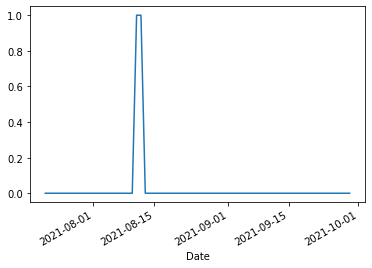

In [352]:
def consolidating_in_range(series, lookback, percentage):
    """
    This function calculates whether a stock is consolidating or not. 
    It returns 1 if the stock has been consolidating within a "percentage" range over the last N days,
    and 0 if it hasn't. 
    The inputs required are:
    - series: an input time series to calculate the consolidation periods on
    - lookback: the number of periods to check for consolidation within
    - percentage: the range the stock should be consolidating within
    
    The function returns a signal of 1's and 0's.
    
    An idea: combine this signal with a dataloader that obtains the most recent quarterly report and runs "some tests"
    (to be defined) on whether the stock is doing well from a fundamental point of view, and then if it is, places a position. 
    """
    
    # calculating the highs and lows 
    highs = series.rolling(lookback).max()
    lows = series.rolling(lookback).min()
    
    # temporary variable to hold the adjusted highs
    tmp = highs * (100 - percentage)/100
    
    # returns 1 or 0 representing a period the stock is consolidating for N days and vice versa
    is_consolidating = lows.ge(tmp).astype(int)
    
    return is_consolidating

signal = n_day_range(stock["Close"], 15, 2)


### Fractal Indicator

In [264]:
def fractal_indicator(n, k, series):
    """
    Calculates the fractal indicator according to Chapter 20 of "New Technical Indicators in Python" by Sofien Kabaar.
    Takes inputs of:
    - n: mean/standard deviation lookback period
    - k: max/min lookback period 
    - series: pandas series to calculate the fractal indicator on 
    
    Requirements for inputs: 1 <= k <= n 
    
    The output is the fractal indicator. The FI indicates a trend reversal whenever it reaches or nears 1. If the market
    is trending upwards, expect short term reversal to the downside. If the market is trending downwards, expect short term
    reversal to the upside. 
    """
    
    # calculating maxs, mins, means, and stds 
    maxes = series.rolling(k).max().dropna().rename("Max {}".format(k))
    mins = series.rolling(k).min().dropna().rename("Min {}".format(k))
    mean = series.rolling(n).mean().dropna().rename("Mean {}".format(n))
    std = series.rolling(n).std().dropna().rename("Std {}".format(n))

    # concatenating into a df
    req_data = pd.concat([maxes, mins, mean, std], axis=1).dropna()

    # calculating sub ranges 
    req_data["Max less Mean"] = req_data["Max {}".format(k)] - req_data["Mean {}".format(n)]
    req_data["Min less Mean"] = req_data["Min {}".format(k)] - req_data["Mean {}".format(n)]

    # calculating fractal indicator
    req_data["Fractal Indicator"] = (req_data["Max less Mean"] - req_data["Min less Mean"])/req_data["Std {}".format(n)]
    
    return req_data["Fractal Indicator"]

n = 20
k = 14
FI = fractal_indicator(n, k, stock["Close"])

### Volatility Adjusted Stochastic Oscillator

In [274]:
def vol_adj_stoch_osc(series, lookback):
    """
    This functions returns the volatility adjusted stochastic oscillator indicator from Chapter 19 of "New Technical Indicators 
    in Python" by Sofien Kabaar. 
    
    It takes inputs of:
    - series: pandas series to calculate the indicator on
    - lookback: the lookback period to calculate the highs and lows 
    
    It returns an indicator that suggests "overbought" > 80 and "oversold" < 20. 
    """
    maxes = series.rolling(lookback).max().dropna().rename("High")
    mins = series.rolling(lookback).min().dropna().rename("Low")

    df = pd.concat([series, maxes, mins], axis=1).dropna()

    VA_stoch_osc = 100*((df["Close"] - df["Low"])/(df["High"] - df["Low"]))
    
    return VA_stoch_osc

lookback = 14
indicator = vol_adj_stoch_osc(stock["Close"], lookback)